In [125]:
using DifferentialEquations
using NLsolve
using Roots
using PyPlot
using Plots
using PyCall

INFO: Recompiling stale cache file /home/vis-528/.julia/lib/v0.6/Combinatorics.ji for module Combinatorics.


LoadError: LoadError: [91mDeclaring __precompile__(true) is only allowed in module files being imported.[39m
while loading /home/vis-528/.julia/v0.6/Combinatorics/src/Combinatorics.jl, in expression starting on line 1

## 9.1 MM, GG and RinzelHH 
Based on equation 9.3

In [157]:
function MM(V)
    # Na action variable
    U = -V - 70
    Alpha = 0.1*(U + 25)./(exp((U+25)/10) - 1)
    Beta = 4*exp(U/18)
    return Alpha./(Alpha + Beta)
end

function GG(V)
    # Equilibrium value of recovery variable W for Hodgkin-Huxley Equations
    S = 1.2714
    U = -V - 70 # for new Rinzel system
    AH = 0.07*exp(U/20)
    BH = (1 + exp((U+30)/10)).^(-1)
    Hh = AH./(AH + BH);  # Na+ inactivation variable
    AN = 0.01*(U+10)./(exp((U+10)/10) - 1)
    BN = 0.125*exp(U/80)
    Nn = AN./(AN + BN)
    return S*(Nn + S*(1 - Hh))./(1 + S^2)
end

function Vnull(W, VX, IE)
    # dV/dt = 0 isocline for Rinzel
    S = 1.2714
    U = -VX - 70  # For new Rinzel formulation
    Alpha = 0.1*(U + 25)./(exp((U+25)/10) - 1)
    Beta = 4*exp(U/18)
    M = Alpha./(Alpha + Beta + 0.000001)
    Result =(IE - 120*M^3*(1-W)*(VX-55) - 36*(W/S)^4*(VX+92) - 0.3*(VX+50.528))^2
end

Vnull (generic function with 1 method)

# RinzelHH.m

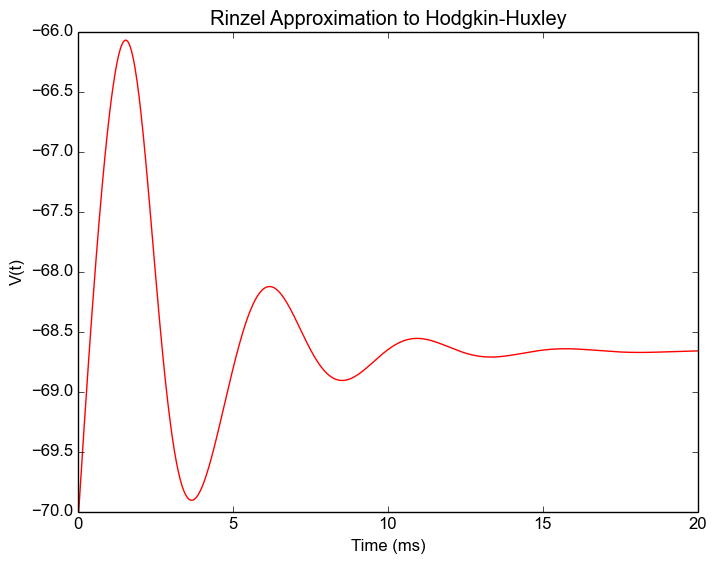

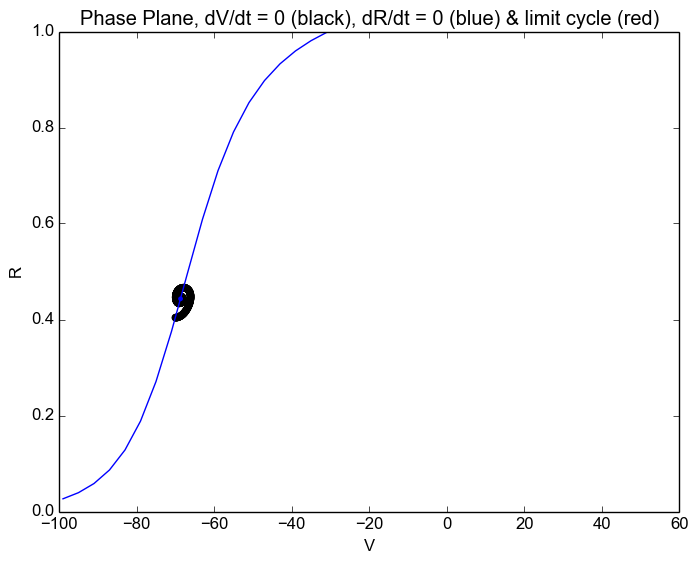

PyObject <matplotlib.text.Text object at 0x7f6656ab4fd0>

In [176]:
#This particular variation has VNa = +55; VK = -92, and VL = -50.52
#Solution of Rinzel-Hodgkin-Huxley Equations
#Tempreature of 16.3 deg C
#The resting potential is -70 mV
DT = 0.02;  #Time increment in msec.
Last = 1000;  #Last time step
Time = DT*[1:Last];  #Time vector
V = zeros(1, Last);  #Vectors to store results
W = zeros(1, Last)
IE = 5# input("Stimulating current (range 0-200): ");  #External Current
S = 1.2714
V[1] = -70;  #Put initial conditions here
W[1] = 0.40388;  #This is the resting value

for T = 2:Last
    VV = V[T-1]
    WW = W[T-1]
    IEE = IE
    for RK = 1:2  #Second Order Runge-Kutta
        M = MM(VV)  #This and following lines calculate V dependent terms
        Geq = GG(VV)  #Winfinity or equilibrium value
        Tau = 5*exp.(-(VV+60)^2/55^2) + 1
        V[T] = V[T-1] + (RK/2)*DT*(IEE - 120*M^3*(1-WW)*(VV-55) - 36*(WW/S)^4*(VV+92) - 0.3*(VV+50.528))
        W[T] = W[T-1] + (RK/2)*DT*(3*(Geq - WW)/Tau)
        VV = V[T]
        WW = W[T]
    end
end

WS = (W - 0.40388)*100 - 70;  #Scaled to approximate units

figure(1)
Pz = PyPlot.plot(Time[1],V[1, :], "r")

xlabel("Time (ms)")
ylabel("V(t)") 
title("Rinzel Approximation to Hodgkin-Huxley")

Wnull = -99:4:61

S = 1.2714
U = -Wnull - 70;  #for new Rinzel system()
AH = 0.07*exp.(U/20)
BH = (1 + exp.((U+30)/10)).^(-1)
Hh = AH./(AH + BH);  #Na+ inactiWnullation Wnullariable
AN = 0.01*(U+10)./(exp.((U+10)/10) - 1)
BN = 0.125*exp.(U/80)
Nn = AN./(AN + BN)
DW = S*(Nn + S*(1 - Hh))./(1 + S^2)


# WW = zeros(23)
# Vplot = linspace(90, 54, length(WW))
# x = linspace(0, .95, 100)
# for j = 1:3#23
#     VX = Vplot[j]
#     WW[j] = fminbnd(Vnull, .1, .95) # THIS FUNCTION DOES NOT EXIST IN JULIA
#     @show WW[j]
# end

figure(2)
# Only plot Wnull vs DW and V vs W
# PF = plot(Wnull, DW, "-b", Vplot, WW, "-k", V, W, "-r")
plot(Wnull, DW, "-b")
scatter(V, W )
axis([-100, 60, 0, 1])
xlabel("V") 
ylabel("R")
title("Phase Plane, dV/dt = 0 (black), dR/dt = 0 (blue) & limit cycle (red)")


# HHWeq.m

In [178]:
using PyPlot

#Fourth Order Runge-Kutta for N-Dimensional Systems

Total_Neurons = 2  #Solve for this number of interacting Neurons
DT = 0.02  #Time increment as fraction of time constant
Final_Time = 20   #Final time value for calculation
Last = Final_Time/DT + 1  #Last time step
Time = DT*[0:Last-1]  #Time vector
Tau = 0.8  #Neural time constants in msec
TauR = 1.9
WTS = [1 2 2 1]  #Runge-Kutta Coefficient weights
for NU = 1:Total_Neurons  #Initialize
    X[NU, :] = zeros(1, Last)  #Vector to store response of Neuron #1
    K[NU, :] = zeros(1, 4)  #Runge-Kutta terms	
    Weights[NU, :] = WTS #Make into matrix for efficiency in main loop
end
X[1, 1] = -0.70  #Initial conditions here if different from zero
X[2, 1] = 0.088  #Initial conditions here if different from zero
Wt2 = [0 .5 .5 1] #Second set of RK weights
rkIndex = [1 1 2 3]
Stim = 1#input("Stimulating current strength (0-2): ")

for T = 2:Last
    for rk = 1:4  #Fourth Order Runge-Kutta
        XH = X[:, T-1] + K[:, rkIndex[rk]]*Wt2[rk]

        K[1, rk] = DT/Tau*(-(17.81 + 47.71*XH[1] + 32.63*XH[1]^2)*(XH[1] - 0.55) - 26*XH[2]*(XH[1] + 0.92) + Stim);  
        K[2, rk] = DT/TauR*(-XH[2] + 1.35*XH[1] + 1.03)

 end
    X[:, T] = X[:, T-1] + sum((Weights.*K)')'/6
end

figure(1)
ZA = plot(Time, 100*X[1, :], "r-")

VV = -0.9:0.01:1.5
DVdt = -0.5*((1.37 + 3.67.*VV + 2.51.*VV.^2).*(VV - 0.55) - Stim/13)./(VV + 0.92)
DRdt = 1.35*VV + 1.03
figure(2)
ZB = plot(VV, DVdt, "k-", VV, DRdt, "b-", X[1, :], X[2, :], "r-")
Spike_Height = max(X[1, round(Last/2):Last])


LoadError: [91mUndefVarError: X not defined[39m